In [1]:
import numpy as np
import itertools
import matplotlib.pyplot as plt
import matplotlib
import time
import pickle
import scipy
from scipy.stats import norm
from scipy.stats import multivariate_normal as mltnorm
from scipy.sparse import csr_matrix
from scipy.stats import randint
from scipy.stats import uniform
from scipy.optimize import minimize
import copy
import math
import time
from scipy.optimize import minimize
from scipy.sparse.linalg import svds
from scipy.linalg import svdvals
import scipy
from sklearn.datasets import load_svmlight_file
import pickle
from pathlib import Path
%matplotlib inline

In [2]:
from functions import *

In [3]:
from algorithms_comp import *

In [4]:
%load_ext autoreload

In [5]:
%aimport algorithms_comp
%aimport -algorithms_comp
%aimport algorithms_comp

In [6]:
from utils import *

# Logistic regression

## a9a

In [7]:
%%time
dataset = "a9a"
A, y, m, n, sparsity_A = prepare_data(dataset)
print("Number of functions in the sum: ", m, ", dimension of the problem: ", n)
L, average_L, worst_L = compute_L(dataset, A)
denseA = A.toarray()
print("Smoothness constant of the sum: ", L)
print("Average smoothness constant   : ", average_L)
print("Worst smoothness constant     : ", worst_L)
print("Fraction of non-zero elemenst : ", sparsity_A)

Number of functions in the sum:  32561 , dimension of the problem:  123
Smoothness constant of the sum:  1.5719196992226567
Average smoothness constant   :  3.467276803535652
Worst smoothness constant     :  3.5
Fraction of non-zero elemenst :  0.11275696922074716
CPU times: total: 219 ms
Wall time: 259 ms


### Find the solution

In [8]:
filename=dataset+"_x_init_all_ones"
x_init = np.ones(n)
l2 = 0
l1 = 0

In [9]:
%%time
param = [A, y, l2, False]
res_solver = minimize(logreg_loss, x_init, args = param, jac=logreg_grad, 
                      method='L-BFGS-B',
                      options={'maxiter':10000, 'disp':True}, tol=1e-10)

print(res_solver.success)
print(res_solver.fun)
print(res_solver)

True
0.3226210397522315
  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 0.3226210397522315
        x: [-1.209e+00 -2.254e-01 ...  1.178e-01 -7.741e-01]
      nit: 1175
      jac: [ 1.449e-07 -5.589e-08 ...  7.681e-08  1.285e-07]
     nfev: 1332
     njev: 1332
 hess_inv: <123x123 LbfgsInvHessProduct with dtype=float64>
CPU times: total: 3.94 s
Wall time: 3.94 s


In [10]:
save_solution(dataset, l2, l1, np.array(res_solver.x), res_solver.fun)

# Parameters

In [11]:
l2 = 0
l1 = 0
sparse = False
sparse_full = True


bs = y.shape[0]

x_star = read_solution(dataset, l2, l1)[0]
f_star = read_solution(dataset, l2, l1)[1]

num_of_non_zeros = 1
x_init = deepcopy(x_star)
shift_param = 11.0
x_init[0:num_of_non_zeros] += shift_param
N = 100

filename = dataset+"_init_first_"+str(num_of_non_zeros)+"_shift_"+str(shift_param)
delta = 0
t = 0.1
param = [logreg_loss, A, y, l2, sparse, sparse_full, L, delta, t]


print("f(x_0)-f(x^*) = ", logreg_loss(x_init, [A, y, l2, False, t]) - f_star)
epsilon = 1e-3

f(x_0)-f(x^*) =  1.0153286848598824


# Tests for ZO-AccSGD

Tuning learning rate and batchsize

In [26]:
%%time
step_param = 1e-1
Our_method = ZO_AccSGD(filename, x_init, args=param, bs=bs, N=N, f_star=f_star, x_star=x_star, tuning_stepsize_param=step_param)
print('Finished with lr = {} and bs = {}'.format(step_param, bs))

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:32<00:00,  3.08it/s]

Finished with lr = 0.1 and bs = 32561
CPU times: total: 47.1 s
Wall time: 32.5 s


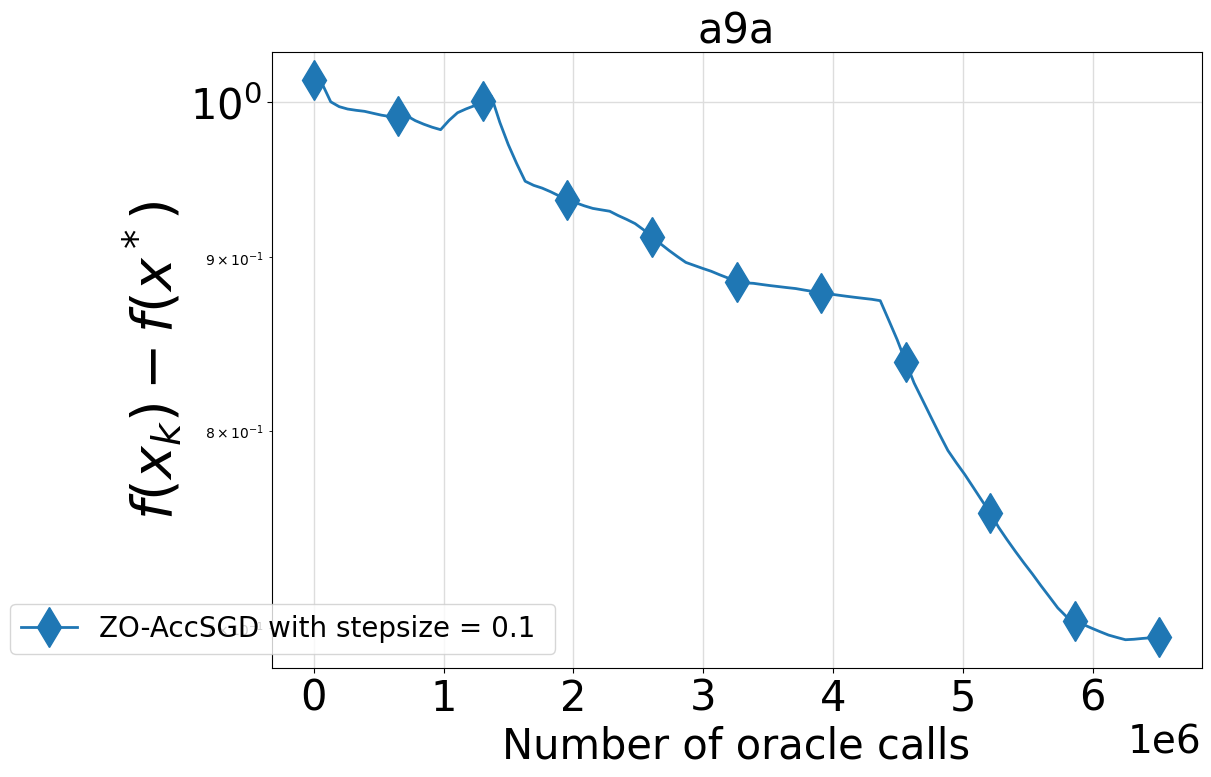

In [27]:
method = []
method.append(['Our_algorithm logreg', [step_param, N, delta, bs], f"ZO-AccSGD with stepsize = {step_param} ", None])


mode_y = 'func_vals'
mode_x = 'oracle_calls'
figsize = (12, 8)
title_size = 30
linewidth = 2
markersize = 20
legend_size = 20
xlabel_size = 30
ylabel_size = 40
xticks_size = 30
yticks_size = 30
sizes = [title_size, linewidth, markersize, legend_size, xlabel_size, ylabel_size, xticks_size, yticks_size]
title = dataset
bbox_to_anchor = (0.32,0)
legend_loc=4

save_fig = [True, filename+"Our_algorithm"+"_delta_"+str(delta)
            +"_batch_"+str(m)+".pdf"]

args_for_plots = [filename, mode_y, mode_x, figsize, sizes, title, method, bbox_to_anchor, legend_loc, save_fig]
make_plots(args_for_plots)

In [29]:
%%time
# tuning_stepsize_param_options_ardfds_e = [1e-1, 2e-2, 3e-2, 4e-2, 5e-2, 6e-2]
N = 100
stepsizes = [1e-1, 1e-2, 1e-3]
batchsizes = [1000, 10000, 30000]
for step_param in stepsizes:
    for bs in batchsizes: 
        Our_method = ZO_AccSGD(filename, x_init, args=param, bs=bs, N=N,
                            f_star=f_star, x_star=x_star, tuning_stepsize_param=step_param)
        print('Finished with lr = {} and bs = {}'.format(step_param, bs))

  0%|          | 0/3256 [00:00<?, ?it/s]

100%|██████████| 3256/3256 [00:57<00:00, 57.05it/s]


Finished with lr = 0.1 and bs = 1000


100%|██████████| 325/325 [00:36<00:00,  8.80it/s]


Finished with lr = 0.1 and bs = 10000


100%|██████████| 108/108 [00:31<00:00,  3.39it/s]


Finished with lr = 0.1 and bs = 30000


100%|██████████| 3256/3256 [00:57<00:00, 56.54it/s]


Finished with lr = 0.01 and bs = 1000


100%|██████████| 325/325 [00:37<00:00,  8.74it/s]


Finished with lr = 0.01 and bs = 10000


100%|██████████| 108/108 [00:32<00:00,  3.32it/s]


Finished with lr = 0.01 and bs = 30000


100%|██████████| 3256/3256 [00:58<00:00, 55.58it/s]


Finished with lr = 0.001 and bs = 1000


100%|██████████| 325/325 [00:37<00:00,  8.70it/s]


Finished with lr = 0.001 and bs = 10000


100%|██████████| 108/108 [00:32<00:00,  3.35it/s]

Finished with lr = 0.001 and bs = 30000
CPU times: total: 7min 31s
Wall time: 6min 21s


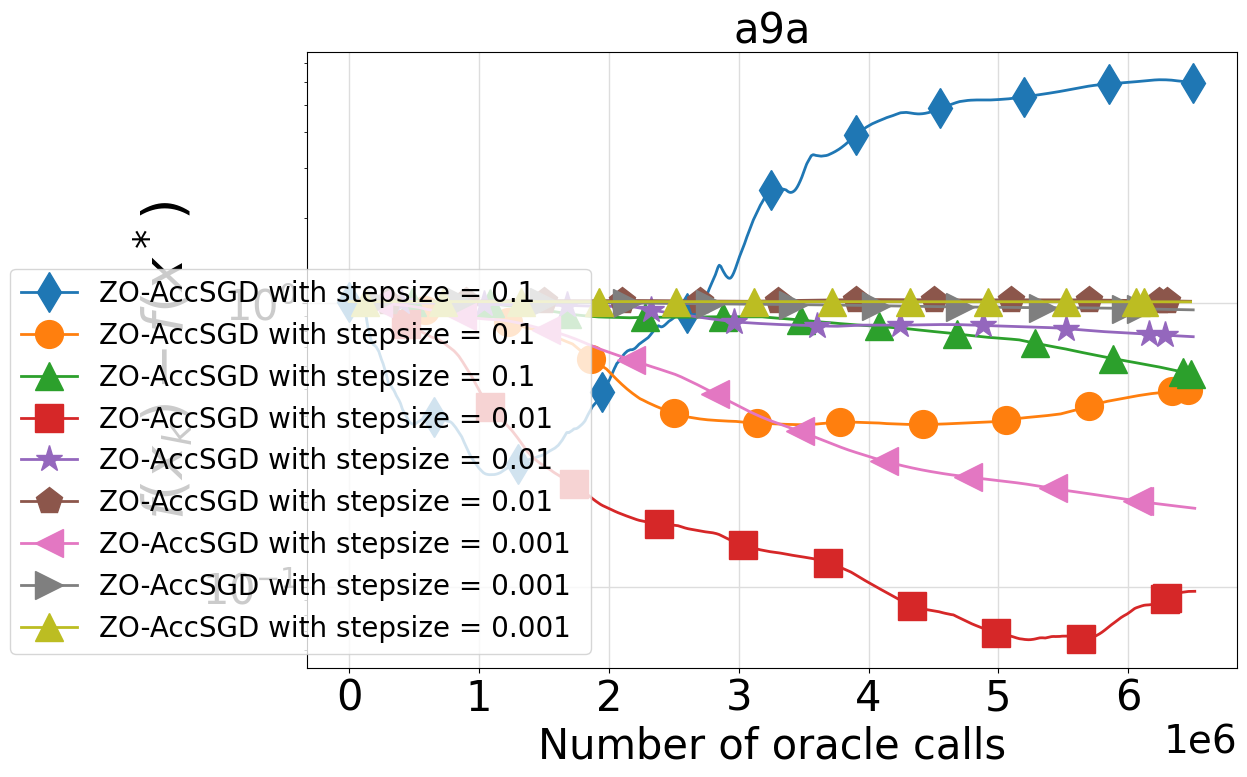

In [31]:
methods = []
# rho_list = [1e-1, 2e-2, 3e-2, 4e-2, 5e-2, 6e-2]
stepsizes = [1e-1, 1e-2, 1e-3]
batchsizes = [1000, 10000, 30000]

for step_param in stepsizes:
    for bs in batchsizes: 
        methods.append(['Our_algorithm logreg', [step_param, N, delta, bs],
                        f"ZO-AccSGD with stepsize = {step_param} ", None])


mode_y = 'func_vals'
mode_x = 'oracle_calls'
figsize = (12, 8)
title_size = 30
linewidth = 2
markersize = 20
legend_size = 20
xlabel_size = 30
ylabel_size = 40
xticks_size = 30
yticks_size = 30
sizes = [title_size, linewidth, markersize, legend_size, xlabel_size, ylabel_size, xticks_size, yticks_size]
title = dataset
bbox_to_anchor = (0.32,0)
legend_loc=4

save_fig = [True, filename+"Our_algorithm"+"_delta_"+str(delta)
            +"_batch_"+str(m)+".pdf"]

args_for_plots = [filename, mode_y, mode_x, figsize, sizes, title, methods, bbox_to_anchor, legend_loc, save_fig]
make_plots(args_for_plots)

Easy to see that with params lr = 1e-2 and bs = 1000; lr = 1e-3 and bs = 100 method has the best convergence. Let's enlarge N:

In [16]:
%%time
# tuning_stepsize_param_options_ardfds_e = [1e-1, 2e-2, 3e-2, 4e-2, 5e-2, 6e-2]
stepsizes = [1e-2, 1e-3]
batchsizes = [1000, 100]
for step_param, bs in zip(stepsizes, batchsizes):
    for N in [100, 200, 500]:
        Our_method = ZO_AccSGD(filename, x_init, args=param, bs=bs, N=N,
                            f_star=f_star, x_star=x_star, tuning_stepsize_param=step_param)
        print('Finished after {} iters with lr = {} and bs = {}'.format(N, step_param, bs))

100%|██████████| 3256/3256 [00:10<00:00, 305.67it/s]


Finished after 100 iters with lr = 0.01 and bs = 1000


100%|██████████| 6512/6512 [00:20<00:00, 314.56it/s]


Finished after 200 iters with lr = 0.01 and bs = 1000


100%|██████████| 16280/16280 [00:51<00:00, 314.05it/s]


Finished after 500 iters with lr = 0.01 and bs = 1000


100%|██████████| 32561/32561 [00:48<00:00, 666.95it/s]


Finished after 100 iters with lr = 0.001 and bs = 100


100%|██████████| 65122/65122 [01:19<00:00, 823.35it/s]


Finished after 200 iters with lr = 0.001 and bs = 100


100%|██████████| 162805/162805 [02:39<00:00, 1017.54it/s]

Finished after 500 iters with lr = 0.001 and bs = 100
CPU times: total: 6min 5s
Wall time: 6min 11s


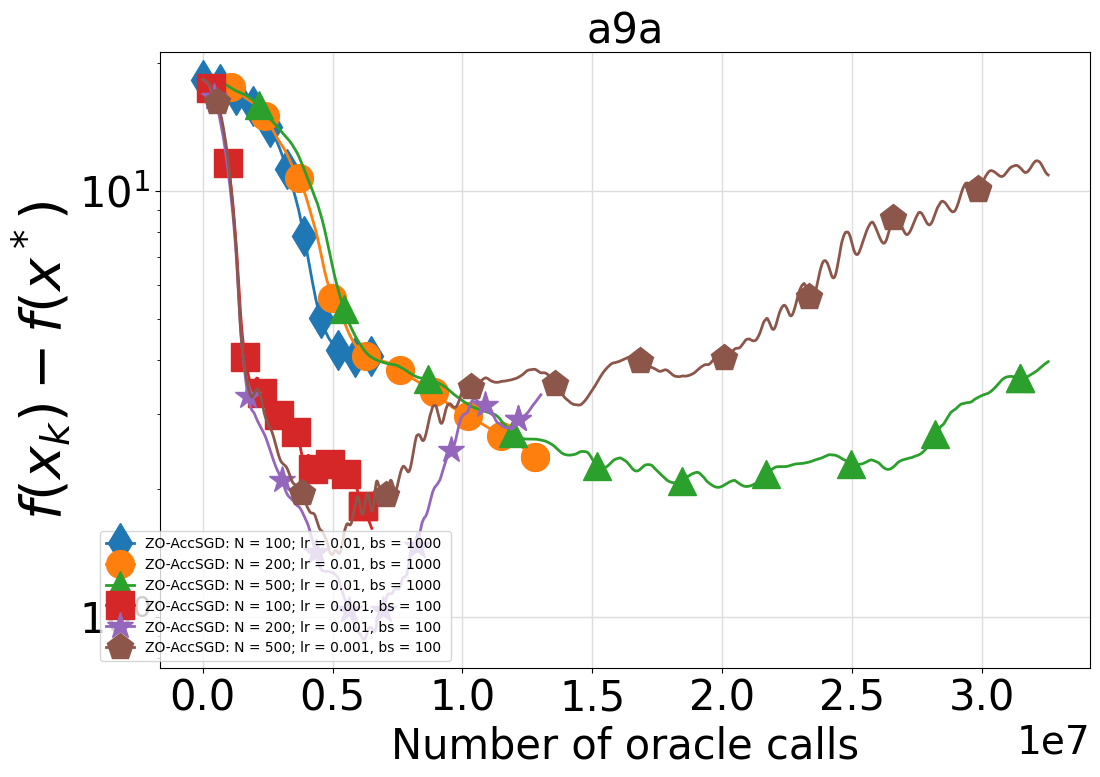

In [18]:
methods = []
# rho_list = [1e-1, 2e-2, 3e-2, 4e-2, 5e-2, 6e-2]
stepsizes = [1e-2, 1e-3]
batchsizes = [1000, 100]
for step_param, bs in zip(stepsizes, batchsizes):
    for N in [100, 200, 500]:
        methods.append(['Our_algorithm logreg', [step_param, N, delta, bs],
                        f"ZO-AccSGD: N = {N}; lr = {step_param}, bs = {bs} ", None])


mode_y = 'func_vals'
mode_x = 'oracle_calls'
figsize = (12, 8)
title_size = 30
linewidth = 2
markersize = 20
legend_size = 10
xlabel_size = 30
ylabel_size = 40
xticks_size = 30
yticks_size = 30
sizes = [title_size, linewidth, markersize, legend_size, xlabel_size, ylabel_size, xticks_size, yticks_size]
title = dataset
bbox_to_anchor = (0.32,0)
legend_loc=4

save_fig = [True, filename+"Our_algorithm"+"_delta_"+str(delta)
            +"_batch_"+str(m)+".pdf"]

args_for_plots = [filename, mode_y, mode_x, figsize, sizes, title, methods, bbox_to_anchor, legend_loc, save_fig]
make_plots(args_for_plots)

Best local convergence is shown with lr = 1e-3 and bs = 100. However, global convergence is not present -- strange behaviour. 

In [28]:
# Proposed in the paper
from scipy.stats import multivariate_normal

def ZO_AccSGD_new(filename, x_init, args, bs=1, N=100, f_star=None, x_star=None, tuning_stepsize_param=1.0):
    n = len(x_init)

    if f_star == None:
        f_star = 0

    f = args[0]
    A = args[1]
    y = args[2]
    l2 = args[3]
    sparse = args[4]
    sparse_full = args[5]
    L = args[6]
    delta = args[7]

    theoretical = False

    t = args[-1]

    m, n = A.shape

    # Smooth constant 
    beta = 5

    def compute_Kernal(beta, r):
        if (beta == 1 or beta == 2):
            Kernal = 3*r
        elif (beta == 3 or beta == 4):
            Kernal = ((15*r) / 4) * (5 - 7 * r**3)
        elif (beta == 5 or beta == 6):
            Kernal = ((195*r) / 64) * (99 * r**4 - 126 * r**2 + 35)
        return Kernal
    
    # Parameters setting
    a = 0
    gamma = 0
    alpha = 0

    if theoretical:
        rho = max(1, 4 * n * (3 * beta**3) / bs)
        stepsize = 1. / (L*rho)
    else:
        rho = 1.
        stepsize = tuning_stepsize_param 

    dumping_constant = np.max([int(N*1e5/(bs*1e50)), 1])

    yk = deepcopy(x_init)
    xk = deepcopy(x_init)
    zk = deepcopy(x_init)

    conv_f = np.array([])
    iters = np.array([])
    tim = np.array([])
    sample_complexity = np.array([])

    number_of_directions = 1000
    number_of_samples = np.min([int(N*1e5*1.0/bs), number_of_directions])*n
    temp_arr = norm().rvs(size=number_of_samples)

    directions_counter = 0

    indices = randint.rvs(low=0, high=m, size=min(int(N*1e5*1.0/bs), int(100000/bs))*bs)
    indices_size = len(indices)
    indices_counter = 0

    t_start = time.time()
    tim = np.append(tim, time.time() - t_start)
    iters = np.append(iters, 0)
    conv_f = np.append(conv_f, f(xk,[A, y, l2, sparse_full]) - f_star)
    sample_complexity = np.append(sample_complexity, 0)

    if sparse:
        A_for_batch = A
    else:
        A_for_batch = A.toarray()

    for k in tqdm(range(int(N*1e5*1.0/bs))):

        if directions_counter == number_of_directions-1:
            temp_arr = norm().rvs(size=number_of_samples)
            directions_counter = 0
        if indices_counter == indices_size:
            indices_counter = 0
            indices = randint.rvs(low=0, high=m, size=indices_size)

        batch_ind = indices[indices_counter:(indices_counter+bs)]
        indices_counter += bs

        e_unnormalized = temp_arr[directions_counter*n:(directions_counter+1)*n]
        e = e_unnormalized/np.linalg.norm(e_unnormalized)
        r = np.random.uniform(-1,1)

        Kernal = compute_Kernal(beta, r)

        directions_counter += 1

        # Params update
        a = gamma * np.sqrt(stepsize * rho)
        gamma = (rho**(-1) + np.sqrt(rho**(-2) + 4 * gamma**2)) / 2
        alpha = (gamma * stepsize) / (gamma * stepsize + a**2)

        # Args update
        yk = alpha * zk + (1 - alpha) * xk

        # Calculate grad
        f_1 = f(yk + t*r*e,[A_for_batch[batch_ind], y[batch_ind], l2, sparse])
        f_2 = f(yk - t*r*e,[A_for_batch[batch_ind], y[batch_ind], l2, sparse])

        if theoretical:
            eps = 1e-10
            if bs > 1 and bs <= 15000:
                delta = np.sqrt(eps**3 / n)
            else:
                delta = np.sqrt(np.pow(eps, (3.0 * beta + 1)/(4.0 * (beta - 1))) * np.sqrt(bs) / n)
            xi_1, xi_2 = st.uniform(loc=-delta, scale=2*delta).rvs(size=2)
        else:
            xi_1, xi_2 = st.uniform(loc=-delta, scale=2*delta).rvs(size=2)

        # TODO: откуда вообще берется * 1.0? 
        grad_estim = (((f_1 + xi_1) - (f_2 + xi_2)) * 1.0/(2*t)) * Kernal * e

        xk = yk - grad_estim * stepsize
        zk = zk - gamma* stepsize* grad_estim

        if ((k+1) % dumping_constant == 0):
            iters = np.append(iters, k+1)
            tim = np.append(tim, time.time() - t_start)
            conv_f = np.append(conv_f, f(xk, [A, y, l2, sparse_full]) - f_star)
            sample_complexity = np.append(sample_complexity, (k+1)*2*bs)

    res = {'last_iter'   : xk,
           'func_vals'   : conv_f,
           'iters'       : iters,
           'time'        : tim,
           'oracle_calls': sample_complexity}
    
    with open("dump/"+filename+"Our_algorithm_v1"+str(tuning_stepsize_param)+"_epochs_"+str(N)+
              "_delta_"+str(delta)+"_batch_"+str(bs)+".txt", 'wb') as file:
        pickle.dump(res, file)

    return res

In [31]:
%%time
# tuning_stepsize_param_options_ardfds_e = [1e-1, 2e-2, 3e-2, 4e-2, 5e-2, 6e-2]
stepsizes = [1e-1, 1e-2, 1e-3]
batchsizes = [100, 1000, 10000, 30000]
for step_param in stepsizes:
    for bs in batchsizes: 
        Our_method = ZO_AccSGD_new(filename, x_init, args=param, bs=bs, N=N,
                            f_star=f_star, x_star=x_star, tuning_stepsize_param=step_param)
        print('Finished with lr = {} and bs = {}'.format(step_param, bs))

100%|██████████| 162805/162805 [02:50<00:00, 956.50it/s] 


Finished with lr = 0.1 and bs = 100


100%|██████████| 16280/16280 [00:49<00:00, 327.82it/s]


Finished with lr = 0.1 and bs = 1000


100%|██████████| 1628/1628 [00:19<00:00, 84.86it/s]


Finished with lr = 0.1 and bs = 10000


100%|██████████| 542/542 [00:16<00:00, 32.93it/s]


Finished with lr = 0.1 and bs = 30000


100%|██████████| 162805/162805 [02:39<00:00, 1017.78it/s]


Finished with lr = 0.01 and bs = 100


100%|██████████| 16280/16280 [00:50<00:00, 325.44it/s]


Finished with lr = 0.01 and bs = 1000


100%|██████████| 1628/1628 [00:19<00:00, 84.05it/s]


Finished with lr = 0.01 and bs = 10000


100%|██████████| 542/542 [00:16<00:00, 32.56it/s]


Finished with lr = 0.01 and bs = 30000


100%|██████████| 162805/162805 [02:35<00:00, 1046.12it/s]


Finished with lr = 0.001 and bs = 100


100%|██████████| 16280/16280 [00:49<00:00, 329.77it/s]


Finished with lr = 0.001 and bs = 1000


100%|██████████| 1628/1628 [00:19<00:00, 83.36it/s]


Finished with lr = 0.001 and bs = 10000


100%|██████████| 542/542 [00:16<00:00, 32.66it/s]

Finished with lr = 0.001 and bs = 30000
CPU times: total: 12min 59s
Wall time: 12min 24s


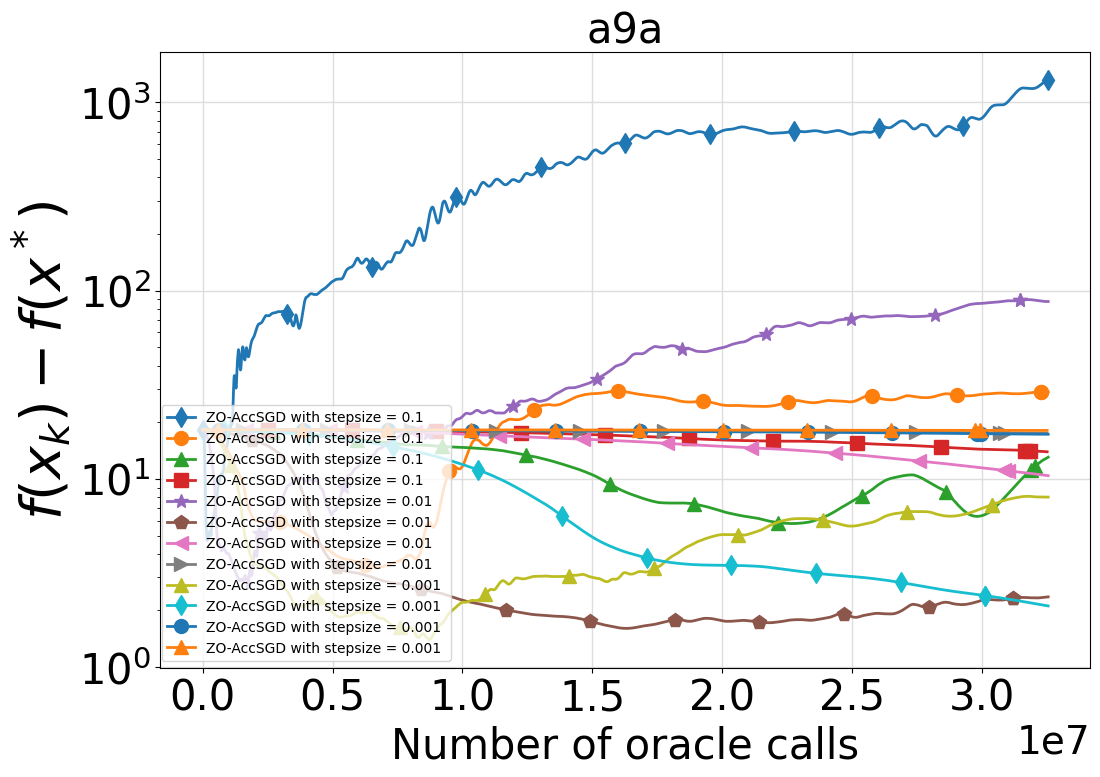

In [33]:
methods = []
# rho_list = [1e-1, 2e-2, 3e-2, 4e-2, 5e-2, 6e-2]
stepsizes = [1e-1, 1e-2, 1e-3]
batchsizes = [100, 1000, 10000, 30000]

for step_param in stepsizes:
    for bs in batchsizes: 
        methods.append(['Our_algorithm_v1 logreg', [step_param, N, delta, bs],
                        f"ZO-AccSGD with stepsize = {step_param} ", None])


mode_y = 'func_vals'
mode_x = 'oracle_calls'
figsize = (12, 8)
title_size = 30
linewidth = 2
markersize = 10
legend_size = 10
xlabel_size = 30
ylabel_size = 40
xticks_size = 30
yticks_size = 30
sizes = [title_size, linewidth, markersize, legend_size, xlabel_size, ylabel_size, xticks_size, yticks_size]
title = dataset
bbox_to_anchor = (0.32,0)
legend_loc=4

save_fig = [True, filename+"Our_algorithm_v1"+"_delta_"+str(delta)
            +"_batch_"+str(m)+".pdf"]

args_for_plots = [filename, mode_y, mode_x, figsize, sizes, title, methods, bbox_to_anchor, legend_loc, save_fig]
make_plots(args_for_plots)

In [30]:
%%time
# tuning_stepsize_param_options_ardfds_e = [1e-1, 2e-2, 3e-2, 4e-2, 5e-2, 6e-2]
stepsizes = [1e-2, 1e-3]
batchsizes = [1000, 100]
for step_param, bs in zip(stepsizes, batchsizes):
    for N in [1000]:
        Our_method = ZO_AccSGD_new(filename, x_init, args=param, bs=bs, N=N,
                            f_star=f_star, x_star=x_star, tuning_stepsize_param=step_param)
        print('Finished after {} iters with lr = {} and bs = {}'.format(N, step_param, bs))

  0%|          | 0/100000 [00:00<?, ?it/s]

100%|██████████| 100000/100000 [05:05<00:00, 327.11it/s]


Finished after 1000 iters with lr = 0.01 and bs = 1000


100%|██████████| 1000000/1000000 [1:56:53<00:00, 142.59it/s]

Finished after 1000 iters with lr = 0.001 and bs = 100
CPU times: total: 2h 56s
Wall time: 2h 1min 58s


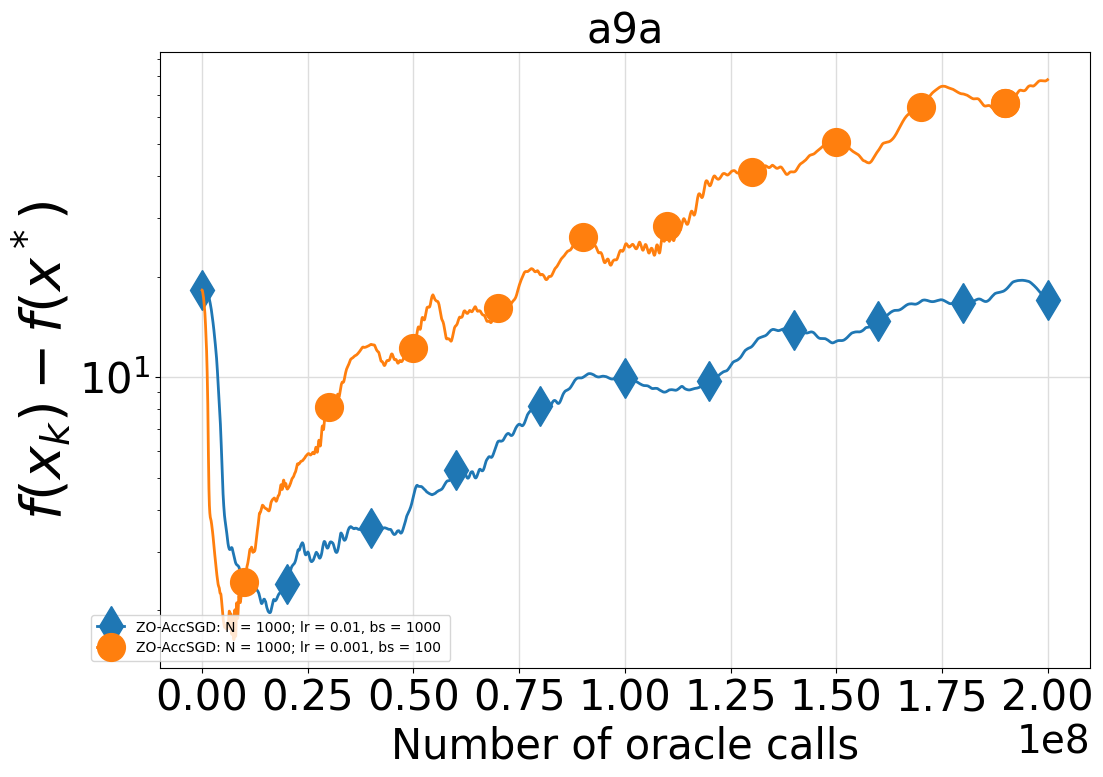

In [32]:
methods = []
# rho_list = [1e-1, 2e-2, 3e-2, 4e-2, 5e-2, 6e-2]
stepsizes = [1e-2, 1e-3]
batchsizes = [1000, 100]
for step_param, bs in zip(stepsizes, batchsizes):
    for N in [1000]:
        methods.append(['Our_algorithm_v1 logreg', [step_param, N, delta, bs],
                        f"ZO-AccSGD: N = {N}; lr = {step_param}, bs = {bs} ", None])


mode_y = 'func_vals'
mode_x = 'oracle_calls'
figsize = (12, 8)
title_size = 30
linewidth = 2
markersize = 20
legend_size = 10
xlabel_size = 30
ylabel_size = 40
xticks_size = 30
yticks_size = 30
sizes = [title_size, linewidth, markersize, legend_size, xlabel_size, ylabel_size, xticks_size, yticks_size]
title = dataset
bbox_to_anchor = (0.32,0)
legend_loc=4

save_fig = [True, filename+"Our_algorithm_v1"+"_delta_"+str(delta)
            +"_batch_"+str(1e5)+".pdf"]

args_for_plots = [filename, mode_y, mode_x, figsize, sizes, title, methods, bbox_to_anchor, legend_loc, save_fig]
make_plots(args_for_plots)

In [13]:
N = 500
stepsizes = [1e-2, 1e-3]
batchsizes = [1000, 10000, 100000]
rhos = [1, 100, 10000]
for step_param in stepsizes:
    for bs in batchsizes: 
        for rho in rhos:
            param = [logreg_loss, A, y, l2, sparse, sparse_full, L, delta, rho, t]
            Our_method = ZO_AccSGD(filename, x_init, args=param, bs=bs, N=N,
                                f_star=f_star, x_star=x_star, tuning_stepsize_param=step_param)
            print('Finished with lr = {}, bs = {}, rho = {}'.format((1 / L) * step_param, bs, rho))

  0%|          | 0/16280 [00:00<?, ?it/s]

100%|██████████| 16280/16280 [04:29<00:00, 60.43it/s]


Finished with lr = 0.006361648120413011, bs = 1000, rho = 1


100%|██████████| 16280/16280 [04:32<00:00, 59.84it/s]


Finished with lr = 0.006361648120413011, bs = 1000, rho = 100


100%|██████████| 16280/16280 [04:32<00:00, 59.73it/s]


Finished with lr = 0.006361648120413011, bs = 1000, rho = 10000


100%|██████████| 1628/1628 [02:53<00:00,  9.39it/s]


Finished with lr = 0.006361648120413011, bs = 10000, rho = 1


100%|██████████| 1628/1628 [02:55<00:00,  9.28it/s]


Finished with lr = 0.006361648120413011, bs = 10000, rho = 100


100%|██████████| 1628/1628 [02:57<00:00,  9.18it/s]


Finished with lr = 0.006361648120413011, bs = 10000, rho = 10000


100%|██████████| 162/162 [02:33<00:00,  1.06it/s]


Finished with lr = 0.006361648120413011, bs = 100000, rho = 1


100%|██████████| 162/162 [02:32<00:00,  1.06it/s]


Finished with lr = 0.006361648120413011, bs = 100000, rho = 100


100%|██████████| 162/162 [02:27<00:00,  1.10it/s]


Finished with lr = 0.006361648120413011, bs = 100000, rho = 10000


100%|██████████| 16280/16280 [04:31<00:00, 60.01it/s]


Finished with lr = 0.0006361648120413012, bs = 1000, rho = 1


100%|██████████| 16280/16280 [04:34<00:00, 59.24it/s]


Finished with lr = 0.0006361648120413012, bs = 1000, rho = 100


100%|██████████| 16280/16280 [04:34<00:00, 59.31it/s]


Finished with lr = 0.0006361648120413012, bs = 1000, rho = 10000


100%|██████████| 1628/1628 [02:55<00:00,  9.27it/s]


Finished with lr = 0.0006361648120413012, bs = 10000, rho = 1


100%|██████████| 1628/1628 [02:55<00:00,  9.29it/s]


Finished with lr = 0.0006361648120413012, bs = 10000, rho = 100


100%|██████████| 1628/1628 [02:55<00:00,  9.30it/s]


Finished with lr = 0.0006361648120413012, bs = 10000, rho = 10000


100%|██████████| 162/162 [02:29<00:00,  1.08it/s]


Finished with lr = 0.0006361648120413012, bs = 100000, rho = 1


100%|██████████| 162/162 [02:27<00:00,  1.09it/s]


Finished with lr = 0.0006361648120413012, bs = 100000, rho = 100


100%|██████████| 162/162 [02:27<00:00,  1.10it/s]

Finished with lr = 0.0006361648120413012, bs = 100000, rho = 10000


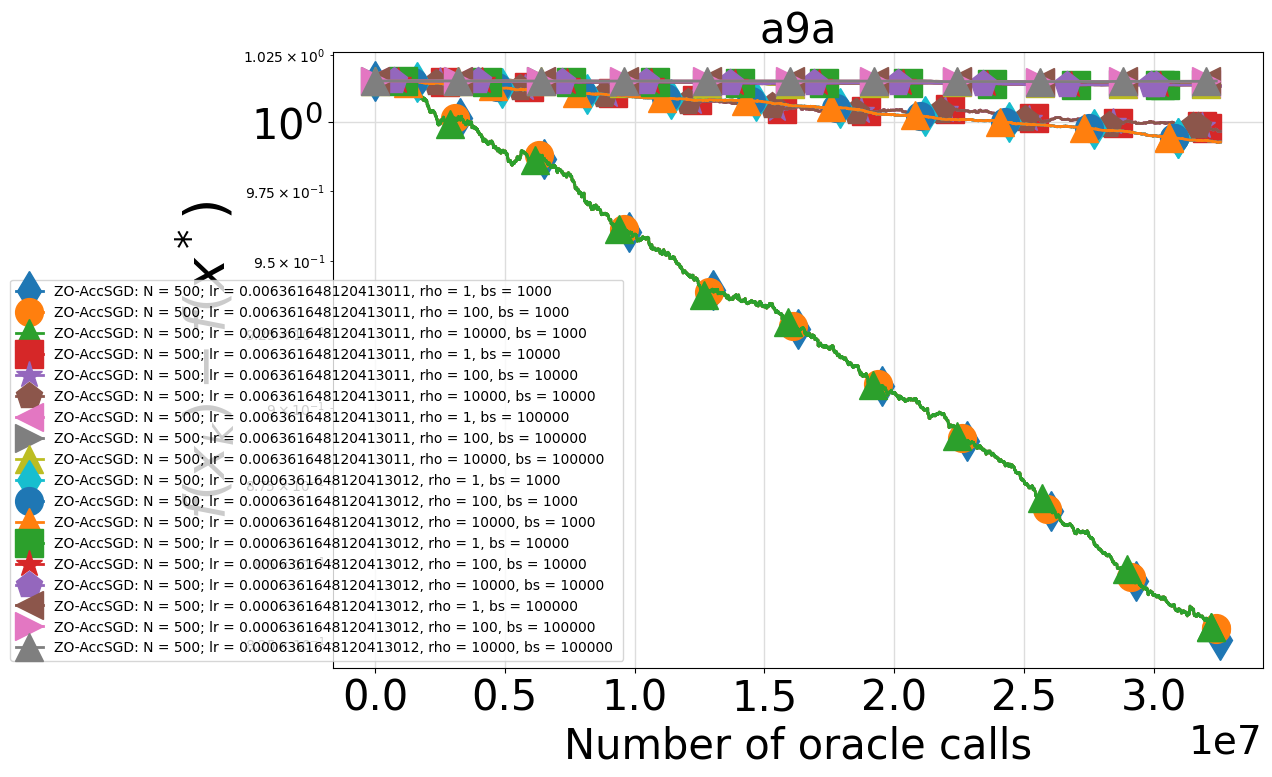

In [14]:
methods = []
N = 500
stepsizes = [1e-2, 1e-3]
batchsizes = [1000, 10000, 100000]
rhos = [1, 100, 10000]
for step_param in stepsizes:
    for bs in batchsizes: 
        for rho in rhos:
            methods.append(['Our_algorithm logreg', [step_param, N, delta, bs],
                        f"ZO-AccSGD: N = {N}; lr = {(1 / L) * step_param}, rho = {rho}, bs = {bs} ", None])


mode_y = 'func_vals'
mode_x = 'oracle_calls'
figsize = (12, 8)
title_size = 30
linewidth = 2
markersize = 20
legend_size = 10
xlabel_size = 30
ylabel_size = 40
xticks_size = 30
yticks_size = 30
sizes = [title_size, linewidth, markersize, legend_size, xlabel_size, ylabel_size, xticks_size, yticks_size]
title = dataset
bbox_to_anchor = (0.32,0)
legend_loc=4

save_fig = [True, filename+"Our_algorithm"+"_delta_"+str(delta)
            +"_batch_"+str(m)+".pdf"]

args_for_plots = [filename, mode_y, mode_x, figsize, sizes, title, methods, bbox_to_anchor, legend_loc, save_fig]
make_plots(args_for_plots)